# Этап 1

## Подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import lightgbm as lgb
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# Объявим константы
RANDOM_STATE = 12345
CV = 5

In [3]:
# Загрузка данных
data = pd.read_csv('Churn.csv')

Проведем исследовательский анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
# Найдем пропуски в данных
pd.DataFrame(round(data.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.000000
Balance,0.000000
NumOfProducts,0.000000


Приведем названия столбцов к нижнему регистру с подчеркиванием. Заполним пропуски и посчитаем количество дубликатов.

In [7]:
data.columns = [x.lower() for x in data.columns]
data.rename(columns={'rownumber': 'row_number', 'customerid': 'customer_id',
                     'creditscore': 'credit_score', 'numofproducts': 'num_of_products',
                    'hascrcard': 'has_cr_card', 'isactivemember': 'is_active_member',
                    'estimatedsalary': 'estimated_salary'}, inplace=True)

In [8]:
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
data['tenure'] = data['tenure'].fillna(0)

In [10]:
data.duplicated().sum()

0

## Исследование задачи

Фамилия человека, порядковый номер и идентификатор не влияют на тот факт продолжит ли он/она сотрудничать с банком или нет. Поэтому удалим данные столбцы. Далее воспользуемся техникой порядкового кодирования и подготовим данные.

In [11]:
data = data.drop(['surname', 'row_number', 'customer_id'], axis=1)

In [12]:
data_ordinal = pd.get_dummies(data, drop_first=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64


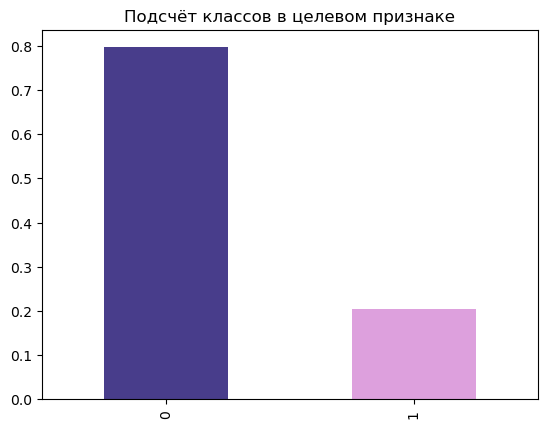

In [13]:
class_frequency = data_ordinal['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(
    kind='bar',
    title="Подсчёт классов в целевом признаке",
    color=['darkslateblue', 'plum'])
plt.show()

In [14]:
# Разделим данные на обучающую, валидационную и тестовую выборки

do_train, do_rem = train_test_split(
    data_ordinal, train_size=0.6, random_state=RANDOM_STATE
)

In [15]:
do_test, do_valid = train_test_split(
    do_rem, test_size=0.5, random_state=RANDOM_STATE
)

In [16]:
# Проверим в нужном ли соотношении разделились датасеты

print(do_train.shape, do_valid.shape, do_test.shape, sep=' ')

(6000, 12) (2000, 12) (2000, 12)


Выделим признаки и целевой признак.

In [17]:
target_train = do_train['exited']
features_train = do_train.drop('exited', axis=1)

target_test = do_test['exited']
features_test = do_test.drop('exited', axis=1)

target_valid = do_valid['exited']
features_valid = do_valid.drop('exited', axis=1)

Масштабируем признаки для дальнейших тестов.

In [18]:
numeric = ['credit_score', 'age', 'tenure',
          'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Обучение моделей

## Без учета дисбаланса

Обучим модели без учета дисбаланса классов.

In [19]:
# Logistic Regression
model_lr_imb = LogisticRegression(random_state=RANDOM_STATE, 
                              solver='liblinear', 
                              )
model_lr_imb.fit(features_train, target_train)
predicted_valid_lr_imb = model_lr_imb.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_lr_imb))

F1: 0.27478260869565213


In [20]:
%%time

param_dt = {
    'max_depth' : range(1, 15)
}

model_dt_imb = DecisionTreeClassifier(random_state=RANDOM_STATE)
search_dt_imb = RandomizedSearchCV(model_dt_imb, param_dt, cv=CV, scoring='f1')
search_dt_imb.fit(features_train, target_train)
model_dt__imb_final = search_dt_imb.best_estimator_
f1_dt_imb = search_dt_imb.best_score_
print('Лучшее значение F1:', f1_dt_imb)
print('Лучшие гиперпараметры Decision Tree:', search_dt_imb.best_params_)

Лучшее значение F1: 0.562638006292574
Лучшие гиперпараметры Decision Tree: {'max_depth': 7}
CPU times: total: 531 ms
Wall time: 533 ms


In [21]:
%%time

param_rf = {
    'n_estimators': range(50, 301, 50),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 5)
}

model_rf_imb = RandomForestClassifier(random_state=RANDOM_STATE)
search_rf_imb = RandomizedSearchCV(model_rf_imb, param_rf, cv=CV, scoring='f1')
search_rf_imb.fit(features_train, target_train)
model_rf_imb_final = search_rf_imb.best_estimator_
f1_rf_imb = search_rf_imb.best_score_
print('Лучшее значение F1:', f1_rf_imb)
print('Лучшие гиперпараметры Random Forest:', search_rf_imb.best_params_)

Лучшее значение F1: 0.5757353734686339
Лучшие гиперпараметры Random Forest: {'n_estimators': 150, 'min_samples_split': 4, 'max_depth': 18}
CPU times: total: 1min 4s
Wall time: 1min 4s


In [22]:
%%time

param_lgbm = {'num_leaves' : range(2, 5), 
              'max_depth' : range(1, 10),
              'n_estimators' : range(50, 301, 50),
             'learning_rate' : [0.1, 0.01, 0.001]}

model_boost_imb = lgb.LGBMClassifier(random_state=RANDOM_STATE)
search_boost_imb = RandomizedSearchCV(model_boost_imb, param_lgbm,
                        cv=CV, scoring='f1')
search_boost_imb.fit(features_train, target_train)
model_boost_imb_final = search_boost_imb.best_estimator_
f1_lgbm_imb = search_boost_imb.best_score_
print('Лучшее значение F1:', f1_lgbm_imb)
print('Лучшие гиперпараметры LGBM:', search_boost_imb.best_params_)

Лучшее значение F1: 0.5828779810602456
Лучшие гиперпараметры LGBM: {'num_leaves': 3, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1}
CPU times: total: 15.2 s
Wall time: 2.35 s


## Борьба с дисбалансом

### Балансировка весов классов

Посмотрим насколько изменится F1 при установки сбалансированного веса классов.

In [23]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, 
                              solver='liblinear', 
                              class_weight='balanced')
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_lr))

F1: 0.4797238999137188


In [24]:
%%time

model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_dt = RandomizedSearchCV(model_dt, param_dt, cv=CV, scoring='f1')
search_dt.fit(features_train, target_train)
model_dt__final = search_dt.best_estimator_
f1_dt = search_dt.best_score_
print('Лучшее значение F1:', f1_dt)
print('Лучшие гиперпараметры Decision Tree:', search_dt.best_params_)

Лучшее значение F1: 0.5579244727142395
Лучшие гиперпараметры Decision Tree: {'max_depth': 6}
CPU times: total: 1.61 s
Wall time: 1.26 s


In [25]:
%%time

model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_rf = RandomizedSearchCV(model_rf, param_rf, cv=CV, scoring='f1')
search_rf.fit(features_train, target_train)
model_rf_final = search_rf.best_estimator_
f1_rf = search_rf.best_score_
print('Лучшее значение F1:', f1_rf)
print('Лучшие гиперпараметры Random Forest:', search_rf.best_params_)

Лучшее значение F1: 0.6090004675322068
Лучшие гиперпараметры Random Forest: {'n_estimators': 150, 'min_samples_split': 4, 'max_depth': 10}
CPU times: total: 57.4 s
Wall time: 57.5 s


In [26]:
%%time

model_boost = lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_boost = RandomizedSearchCV(model_boost, param_lgbm,
                        cv=CV, scoring='f1')
search_boost.fit(features_train, target_train)
model_boost_final = search_boost.best_estimator_
f1_lgbm = search_boost.best_score_
print('Лучшее значение F1:', f1_lgbm)
print('Лучшие гиперпараметры LGBM:', search_boost.best_params_)

Лучшее значение F1: 0.602231759708779
Лучшие гиперпараметры LGBM: {'num_leaves': 3, 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.1}
CPU times: total: 14.1 s
Wall time: 2.05 s


Значение метрики увеличилось, но дисбаланс все еще присутствует.

### Увеличение выборки

Увеличим выборку для того чтобы убрать дисбаланс в классах.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [28]:
print(features_upsampled.shape)

(9588, 11)


Посмотрим как изменился баланс классов после увеличения выборки.

In [29]:
class_frequency1 = target_upsampled.value_counts(normalize=True)
print(class_frequency1)

0    0.501043
1    0.498957
Name: exited, dtype: float64


Обучим модели на сбалансированной выборке и найдем подходящие гиперпараметры.

In [30]:
model_lr.fit(features_upsampled, target_upsampled)
predicted_valid_lr_up = model_lr.predict(features_valid)
f1_lr_up = f1_score(target_valid, predicted_valid_lr_up)
print("F1:", f1_lr_up)

F1: 0.4793103448275862


In [31]:
%%time

model_dt_up = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_dt_up = RandomizedSearchCV(model_dt, param_dt, cv=CV, scoring='f1')
search_dt_up.fit(features_upsampled, target_upsampled)
model_dt_up_final = search_dt_up.best_estimator_
f1_dt_up = search_dt_up.best_score_
print('Лучшее значение F1:', f1_dt_up)
print('Лучшие гиперпараметры Decison Tree:', search_dt_up.best_params_)

Лучшее значение F1: 0.8787452466872787
Лучшие гиперпараметры Decison Tree: {'max_depth': 12}
CPU times: total: 1.77 s
Wall time: 1.79 s


In [32]:
predicted_valid_dt_up = model_dt_up_final.predict(features_valid)
f1_dt_up = f1_score(target_valid, predicted_valid_dt_up)
print("F1:", f1_dt_up)

F1: 0.5272914521112256


In [33]:
%%time

model_rf_up = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_rf_up = RandomizedSearchCV(model_rf_up, param_rf, cv=CV, scoring='f1')
search_rf_up.fit(features_upsampled, target_upsampled)
model_rf_up_final = search_rf_up.best_estimator_
f1_rf_up = search_rf_up.best_score_
print('Лучшее значение F1:', f1_rf_up)
print('Лучшие гиперпараметры Random Forest:', search_rf_up.best_params_)

Лучшее значение F1: 0.9610089054492675
Лучшие гиперпараметры Random Forest: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 23}
CPU times: total: 1min 17s
Wall time: 1min 17s


In [34]:
predicted_valid_rf_up = model_rf_up_final.predict(features_valid)
f1_rf_up = f1_score(target_valid, predicted_valid_rf_up)
print("F1:", f1_rf_up)

F1: 0.5778364116094987


In [35]:
%%time

model_boost_up = lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
search_boost_up = RandomizedSearchCV(model_boost_up, param_lgbm,
                        cv=CV, scoring='f1')
search_boost_up.fit(features_upsampled, target_upsampled)
model_boost_up_final = search_boost_up.best_estimator_
f1_lgbm_up = search_boost_up.best_score_
print('Лучшее значение F1:', f1_lgbm_up)
print('Лучшие гиперпараметры LGBM:', search_boost_up.best_params_)

Лучшее значение F1: 0.7846510310571804
Лучшие гиперпараметры LGBM: {'num_leaves': 3, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.1}
CPU times: total: 23.4 s
Wall time: 3.56 s


In [36]:
predicted_valid_lgbm_up = model_boost_up_final.predict(features_valid)
f1_lgbm_up = f1_score(target_valid, predicted_valid_lgbm_up)
print("F1:", f1_lgbm_up)

F1: 0.6131528046421663


In [37]:
summary = pd.DataFrame(
    {
        'F1' : [f1_lr_up, f1_dt_up, f1_rf_up, f1_lgbm_up]
    },
    index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LGBM']
).sort_values(by='F1', ascending=False)
summary

,F1
LGBM,0.613153
Random Forest,0.577836
Decision Tree,0.527291
Logistic Regression,0.479310


## Тестирование модели

Наилучший результат F1 на тренировочной выборке показали: градиентный бустинг и случайный лес. Протестируем эти модели на тестовой выборке установив соответствующие гиперпараметры.

In [38]:
predicted_lgbm_up = model_boost_up_final.predict(features_test)
probabilities_test_lgbm = model_boost_up_final.predict_proba(features_test)
probabilities_one_test_lgbm = probabilities_test_lgbm[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test_lgbm)

print("F1:", f1_score(target_test, predicted_lgbm_up))
print("AUC-ROC", auc_roc)

F1: 0.6109510086455332
AUC-ROC 0.8615570503087969


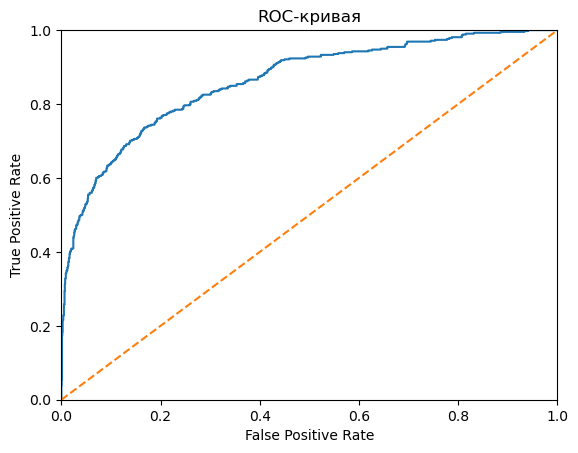

In [39]:
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(target_test, probabilities_one_test_lgbm)

plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [40]:
predicted_rf_up = model_rf_up_final.predict(features_test)
probabilities_test_rf = model_rf_up_final.predict_proba(features_test)
probabilities_one_test_rf = probabilities_test_rf[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test_rf)

print("F1:", f1_score(target_test, predicted_rf_up))
print("AUC-ROC", auc_roc)

F1: 0.6111111111111113
AUC-ROC 0.841420980044641


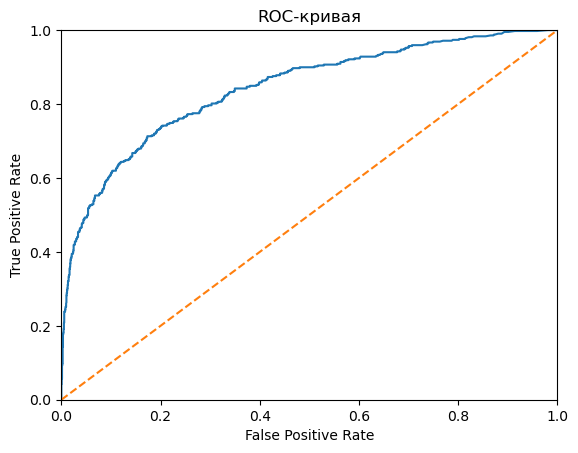

In [41]:
fpr_rf, tpr_rf, thresholds = roc_curve(target_test, probabilities_one_test_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Значения F1 и Auc-roc довольно большие. Это значит, что модель обучена хорошо.

## Вывод

В ходе данной работы было сделано следующее:
- первичный обзор данных, удаление пропусков и ненужных столбцов
- применена техника порядкового кодирования
- подсчет классов целевого признака до изменений
- разделение данных на три выборки: тренировочная, валидационная и тестовая
- масштабирование признаков

Далее модели решающего дерева, случайного леса и логистической регрессии были обучены без учета дисбаланса. Следующим шагом стало обучение моделей с учетом сбалансированного веса классов. После увеличения выборки, модели были протестированы с учетом новых данных, также были найдены соответствующие гиперпарамтеры.

Для финального теста были выбраны дерево решений и случайный лес, так как они показали наилучший результат на предыдущих этапах. Так же были добавлены графики ROC-кривой.

<b>Результат:</b> обе модели показали высокое значение метрик F1 и ROC-AUC.